In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
#  Task 1: Data Preparation (Load, Clean, Prepare) 

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(" Initial Data Inspection ")
df.info()

 Initial Data Inspection 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f"\nMissing values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")

df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

df.drop('customerID', axis=1, inplace=True)

df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

print(" Data Preparation Complete ")
print("TotalCharges handled and Churn column encoded.")
print(df.head())


Missing values in TotalCharges after conversion: 11
 Data Preparation Complete 
TotalCharges handled and Churn column encoded.
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies  

C:\Users\User\AppData\Local\Temp\ipykernel_6104\949376731.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


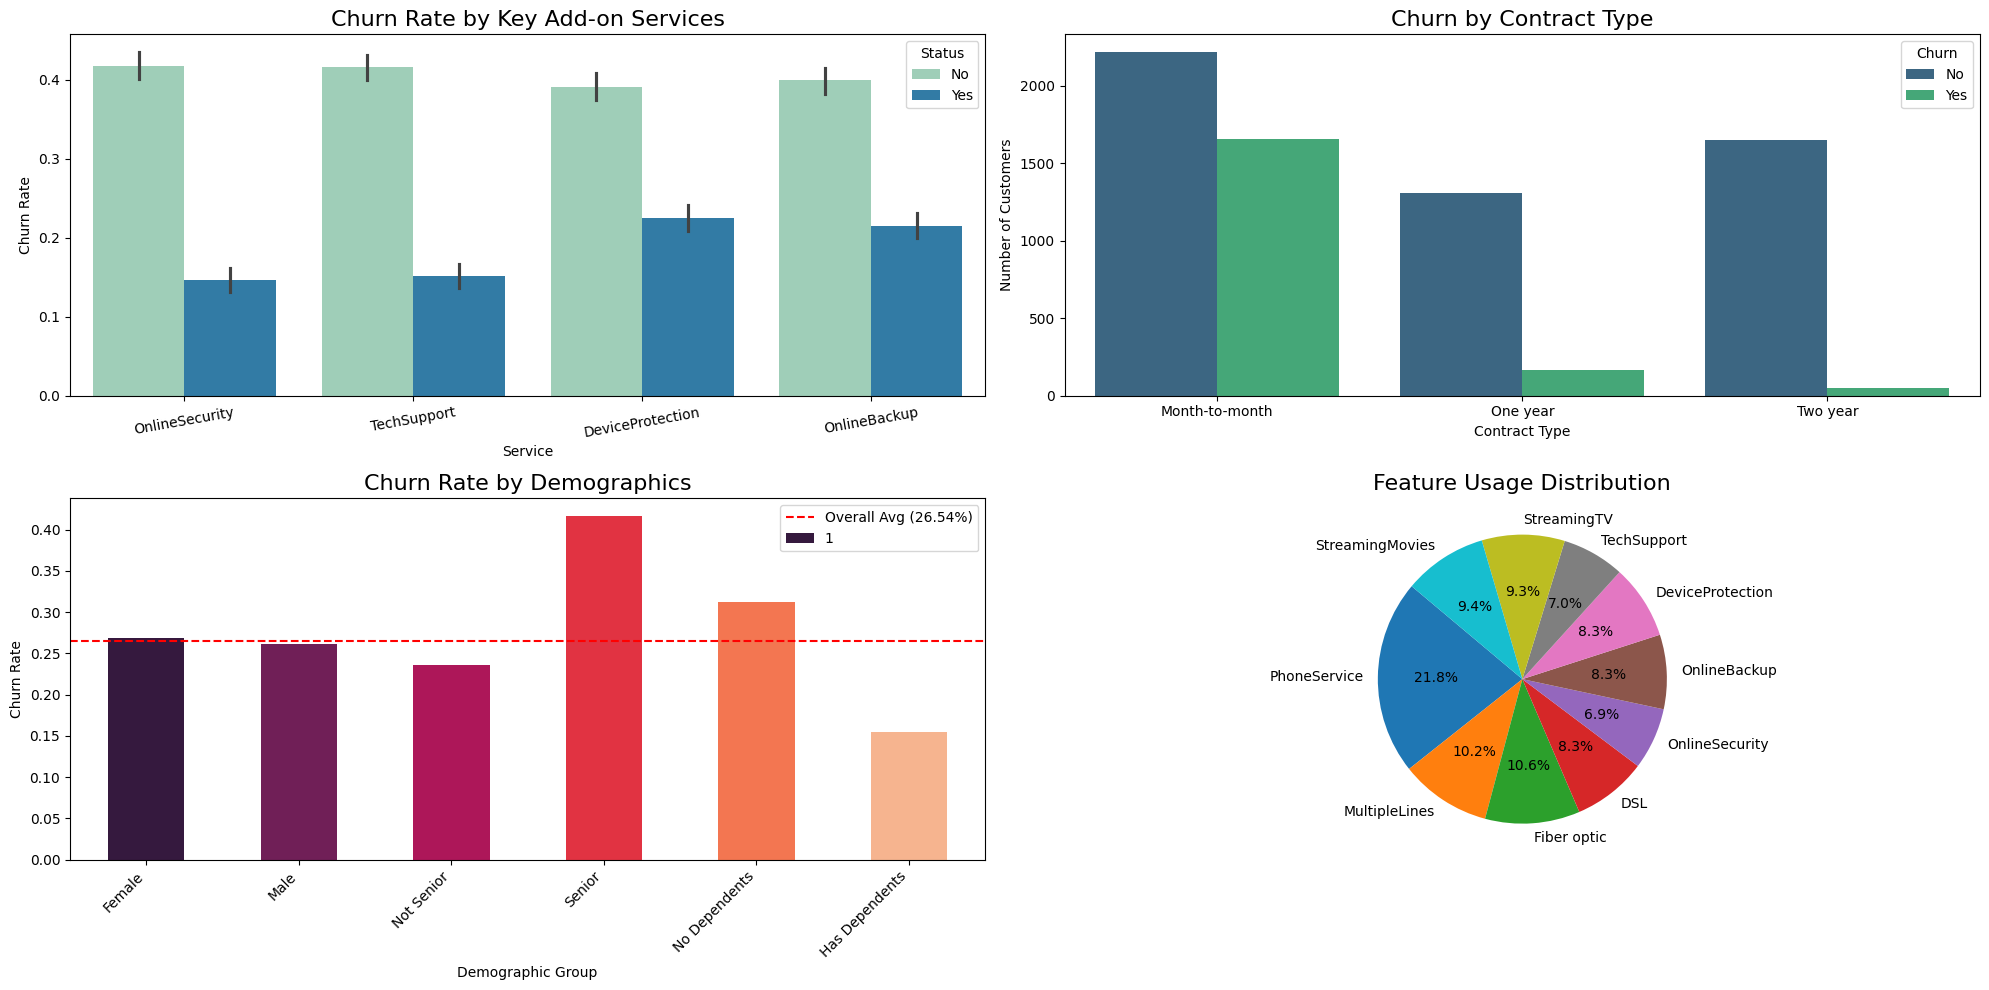

In [4]:
# 2. Detailed Visualizations in a Grid
plt.figure(figsize=(20, 10))

# Plot 2.1: Churn Rate by Key Add-on Services
services = ['OnlineSecurity', 'TechSupport', 'DeviceProtection', 'OnlineBackup']
df_services = df[services + ['Churn']]
df_melted = df_services.melt(id_vars=['Churn'], var_name='Service', value_name='Status')

df_melted = df_melted[df_melted['Status'].isin(['Yes', 'No'])]

plt.subplot(2, 2, 1)
sns.barplot(data=df_melted, x='Service', y='Churn', hue='Status', palette='YlGnBu')
plt.title('Churn Rate by Key Add-on Services', fontsize=16)
plt.ylabel('Churn Rate')
plt.xlabel('Service')
plt.xticks(rotation=10)


# Plot 2.2: Churn by Contract Type
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='Contract', hue='Churn', palette='viridis')
plt.title('Churn by Contract Type', fontsize=16)
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', labels=['No', 'Yes'])

# Plot 2.3: Churn Rate by Demographics
plt.subplot(2, 2, 3)
gender_churn = df.groupby('gender')['Churn'].value_counts(normalize=True).unstack().iloc[:,1]
senior_churn = df.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).unstack().iloc[:,1]
dependents_churn = df.groupby('Dependents')['Churn'].value_counts(normalize=True).unstack().iloc[:,1]

demographic_churn = pd.concat([gender_churn, senior_churn, dependents_churn])
demographic_churn.index = ['Female', 'Male', 'Not Senior', 'Senior', 'No Dependents', 'Has Dependents']

demographic_churn.plot(kind='bar', color=sns.color_palette('rocket'))

overall_churn_rate = df['Churn'].mean()
plt.axhline(y=overall_churn_rate, color='r', linestyle='--', label=f'Overall Avg ({overall_churn_rate:.2%})')
plt.title('Churn Rate by Demographics', fontsize=16)
plt.ylabel('Churn Rate')
plt.xlabel('Demographic Group')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Plot 2.4: Feature Usage Distribution
plt.subplot(2, 2, 4)
feature_usage = df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']]

usage_counts = {}
for col in feature_usage.columns:
    if 'Yes' in df[col].unique():
        usage_counts[col] = df[col].value_counts()['Yes']
    else:
        counts = df[col].value_counts()
        for service_type, count in counts.items():
            if service_type != 'No':
                 usage_counts[service_type] = count

plt.pie(usage_counts.values(), labels=usage_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Feature Usage Distribution', fontsize=16)
plt.ylabel('')


plt.tight_layout()
plt.show()

# EDA Insights
### Correlation Heatmap: 
- tenure is negatively correlated with Churn, confirming that long-term customers are less likely to leave. MonthlyCharges has a positive correlation with churn.

### Churn by Key Services: 
- The bar chart clearly shows that for services like Online Security and Tech Support, customers who do not subscribe have a much higher churn rate. This is a key insight: these services appear to significantly increase customer retention.

### Contract Type: 
- Customers on a Month-to-month contract are the most likely to churn by a large margin. Locking customers into longer contracts is a powerful retention tool.

### Churn by Demographics: 
- Senior citizens have a significantly higher churn rate than the overall average. Customers without dependents also churn more often. Gender does not appear to be a major differentiator in churn rate.

### Feature Usage: 
- The pie chart shows that basic Phone Service is the most widely adopted feature. Among internet-based services, Fiber optic and DSL are the most common. Add-ons like Tech Support and Online Security have lower adoption rates, despite their correlation with lower churn.

Building Predictive Model
Model Performance Metrics
Model Accuracy: 0.81
Confusion Matrix:


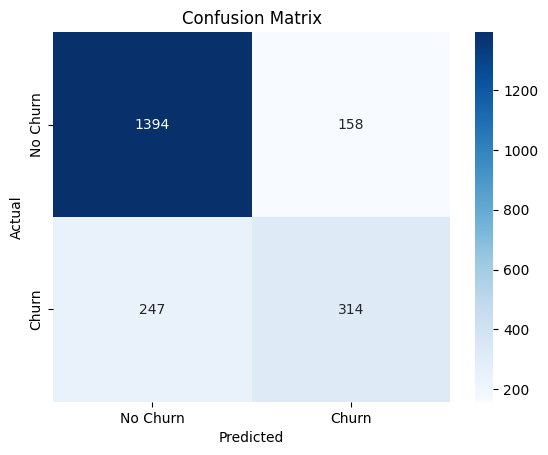

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.87      1552
       Churn       0.67      0.56      0.61       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



In [5]:
# Task 3: Predictive Modelling

print("Building Predictive Model")

X = df.drop('Churn', axis=1)
y = df['Churn']

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=42))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Model Performance Metrics")

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Model Interpretation

- The logistic regression model achieved an accuracy of 81%.

- The model is reasonably good at predicting customers who will not churn (high precision and recall for 'No Churn').

- However, its ability to predict customers who will churn is weaker, because of the dataset imbalance.

- Key Business Takeaway: The factors most influencing churn (like Contract type, Internet Service, and lack of value-add services like Tech Support) should be areas of focus for retention strategies.